In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from comet_ml import Experiment
import time
import os
import pickle
import configparser
np.random.seed(42)
from sklearn.metrics import confusion_matrix
from matplotlib.gridspec import GridSpec
# import xgboost as xgb
# from xgboost import XGBClassifier

from comet_ml.api import API

import warnings
warnings.filterwarnings('ignore')

seed=42

In [2]:
config = configparser.ConfigParser()
config.read('../configfile.ini')
type_env = "comet_ml_prod" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME_REGULAR = config[type_env]['project_name_final_test_regular']
COMET_WORKSPACE = config[type_env]['workspace']

In [3]:
class NeuralNets(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.Softmax()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
def download_models():
    api = API(api_key=COMET_API_KEY)
    list_of_models = ["neural-network-model", "linearmodel-angle", "linearmodel-distance", 
                      "linearmodel-angle-distance"]
    # Download a Registry Model:
    for model_name in list_of_models:
        api.download_registry_model(COMET_WORKSPACE, model_name, "1.0.0",
                                    output_path="../downloaded_models/", expand=True)
    
def load_test_data():
    df = pd.read_pickle("../data/testdata/final_evaluation_set.pkl")
    x_test = df
    x_test["game_type"] = np.where(x_test["game_id"].str[5] == "2", 'regular', 'playoffs')
    x_test = x_test[x_test["game_type"] == "regular"]
    y_test = x_test["is_goal"].values
    
    x_test = x_test[['angle', 'distance_from_last_event', 'empty_net', 'shot_type_Wrap-around', 
                     'y_coordinate', 'speed', 'distance', 'x_coordinate', 'game_period', 'shot_type_Tip-In', 
                     'shot_type_Wrist Shot', 'game_seconds']]
    
    x_test=(x_test-x_test.mean())/x_test.std()
    
    return x_test, y_test

def transform_data_for_nn(x_test, y_test):
    test_data = data_utils.TensorDataset(torch.Tensor(x_test.values.astype(np.float32)), 
                                      torch.LongTensor(y_test.astype(np.float32)))
    batch_size = 64
    # Create data loaders.
    test_dataloader = DataLoader(test_data, batch_size=batch_size)    
    return test_dataloader

In [5]:
# download_models()

In [6]:
comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME_REGULAR,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="Final Evaluation Testing Regular")
comet_exp_obj.log_notebook("12_Final_Evaluation_Testing_regular.ipynb")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/amandalmia/project-name-final-test-regular/475d9dd76f3642aca8180c35a189f1b6



{'web': 'https://www.comet.com/api/asset/download?assetId=f93312e6b370411e9d982a06e09b9e51&experimentKey=475d9dd76f3642aca8180c35a189f1b6',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=f93312e6b370411e9d982a06e09b9e51&experimentKey=475d9dd76f3642aca8180c35a189f1b6',
 'assetId': 'f93312e6b370411e9d982a06e09b9e51'}

In [7]:
x_test, y_test = load_test_data()

comet_exp_obj.log_dataframe_profile(x_test, "x_test", dataframe_format='csv')
comet_exp_obj.log_dataframe_profile(pd.DataFrame(y_test, columns=["is_goal"]), "y_test", dataframe_format='csv')



# Data Prep for Neural Network
test_dataloader = transform_data_for_nn(x_test, y_test)

data_dict = {
    "Neural_Network" : test_dataloader,
#     "kNN" : (x_test, y_test),
#     "Random_Forest" : (x_test, y_test),
#     "Decision_Tree" : (x_test, y_test),
    "LinearModel_Angle" : (x_test, y_test),
    "LinearModel_Angle_Distance" : (x_test, y_test),
    "LinearModel_Distance" : (x_test, y_test)
}

valdataloader = data_dict["Neural_Network"]
x_val = data_dict["LinearModel_Angle"][0]
y_val = data_dict["LinearModel_Angle"][1]

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring


Using cpu device


In [8]:
x_test.shape, y_test.shape

((63991, 12), (63991,))

In [9]:
def get_probs_nn(model, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    pred_list = np.empty((0,2), float)
    true_y = np.empty((0), int)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_list = np.append(pred_list, pred.numpy(), axis=0)
            true_y = np.append(true_y, y.numpy(), axis=0)

    y_val = true_y
    testy = y_val
    ns_probs = [0 for _ in range(len(testy))]
    return pred_list, testy, ns_probs

AUC ROC Scores for BaseLine Model for features -  Neural_Network
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.740
AUC ROC Scores for BaseLine Model for features -  LinearModel_Angle
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.508
AUC ROC Scores for BaseLine Model for features -  LinearModel_Angle_Distance
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.487
AUC ROC Scores for BaseLine Model for features -  LinearModel_Distance
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.698


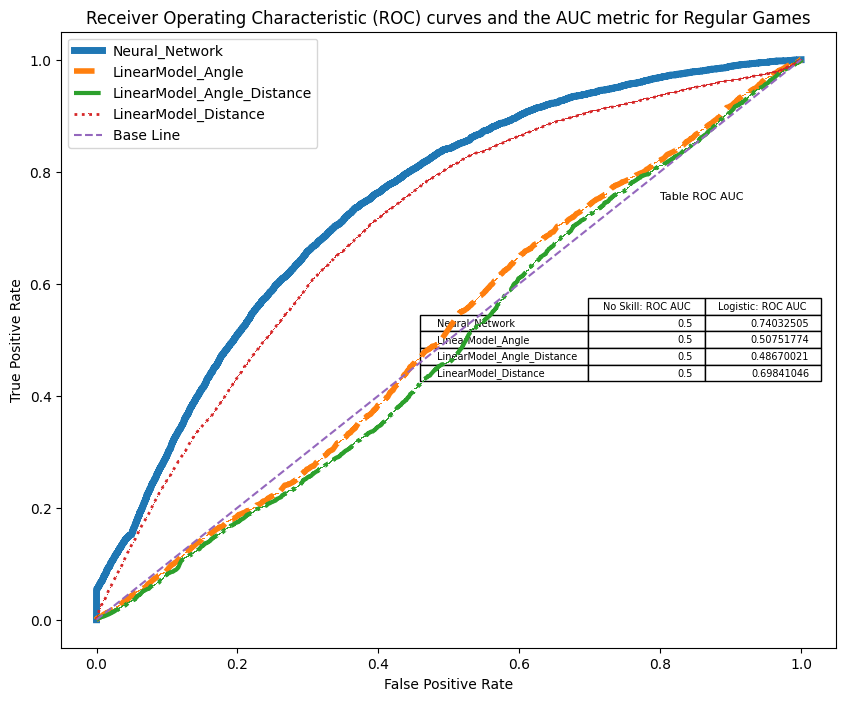

In [10]:
def create_roc_auc_curve(dataloader, x_val, y_val, k): 
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../downloaded_models/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(nn_model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        rf_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = rf_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "LinearModel_Angle":
        x_val = x_val[["angle"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle_Distance":
        x_val = x_val[["angle", "distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Distance":
        x_val = x_val[["distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    else:
        pass

    predicted_probablities = pred_list 
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = round(roc_auc_score(testy, goal_prob), 8)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, goal_prob)
    
    return ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc
    
    
plt.figure(figsize=(10,8))    
table_values = []
markers_list = [",", ",", ",", ",", ",", ",", ","]


for index, (k, v) in enumerate(data_dict.items()):
#     if k == "Random_Forest":
    lw=5-4*index/len(data_dict)
    ls=['-','--','-.',':'][index%4]
    print("AUC ROC Scores for BaseLine Model for features - ", k)
    ns_fpr, ns_tpr, lr_fpr, lr_tpr, ns_auc, lr_auc = create_roc_auc_curve(valdataloader, x_val, y_val, k)
    table_values.append([ns_auc, lr_auc])
    # plot the roc curve for the model
    plt.plot(lr_fpr, lr_tpr, marker=markers_list[index], label=k, linewidth=lw, linestyle=ls)
    
col_labels=['No Skill: ROC AUC','Logistic: ROC AUC']
row_labels=[*data_dict]
table_vals=table_values
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.15]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
plt.text(0.8,0.75,'Table ROC AUC',size=8)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) curves and the AUC metric for Regular Games")
plt.legend()
comet_exp_obj.log_figure(figure_name="Receiver Operating Characteristic (ROC) curves and the AUC metric for Regular Games", 
                             figure=plt, overwrite=True, step=None)
plt.show()


## Dicussion
Yes all of the models perform similar / better to than valdiation set, this is because we did made sure that there is no leakage of the data, the data train on the proper spliting of the data i.e. statified data. 


Goal Shot Rate for BaseLine Model for features -  Neural_Network
Goal Shot Rate for BaseLine Model for features -  LinearModel_Angle
Goal Shot Rate for BaseLine Model for features -  LinearModel_Angle_Distance
Goal Shot Rate for BaseLine Model for features -  LinearModel_Distance


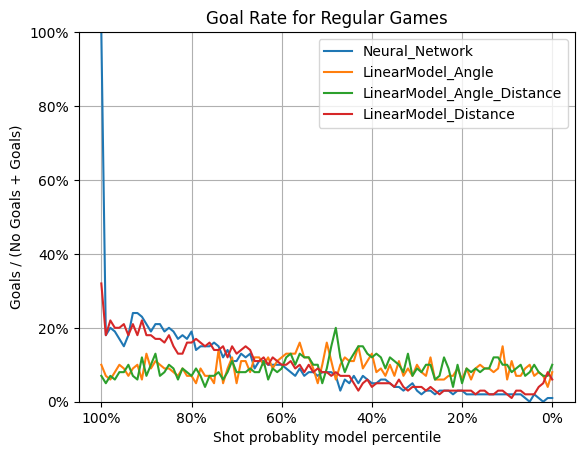

In [11]:
def plot_goal_shot_rate(dataloader, x_val, y_val, k):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../downloaded_models/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(nn_model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        rf_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = rf_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle":
        x_val = x_val[["angle"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle_Distance":
        x_val = x_val[["angle", "distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Distance":
        x_val = x_val[["distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = round((df.groupby(by='percentile_of_goal').sum() / 
                       df.groupby(by='percentile_of_goal').count())*100)
    goal_rate['percentile'] = goal_rate.index

    plt1.plot(goal_rate["percentile"], goal_rate["is_goal"], label=k)


fig, (plt1) = plt.subplots(1, 1)

for index, (k, v) in enumerate(data_dict.items()):
    print("Goal Shot Rate for BaseLine Model for features - ", k)
    plot_goal_shot_rate(valdataloader, x_val, y_val, k)

plt1.set_ylim(0,100)
plt1.xaxis.set_major_formatter('{x:1.0f}%')
plt1.yaxis.set_major_formatter('{x:1.0f}%')
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Goals / (No Goals + Goals)')
plt.grid()
plt.title("Goal Rate for Regular Games")
plt.legend()
comet_exp_obj.log_figure(figure_name="Goal Rate for Regular Games", figure=fig,
                   overwrite=True, step=None)
plt.show()




Cumulative Goal for BaseLine Model for features -  Neural_Network
Cumulative Goal for BaseLine Model for features -  LinearModel_Angle
Cumulative Goal for BaseLine Model for features -  LinearModel_Angle_Distance
Cumulative Goal for BaseLine Model for features -  LinearModel_Distance


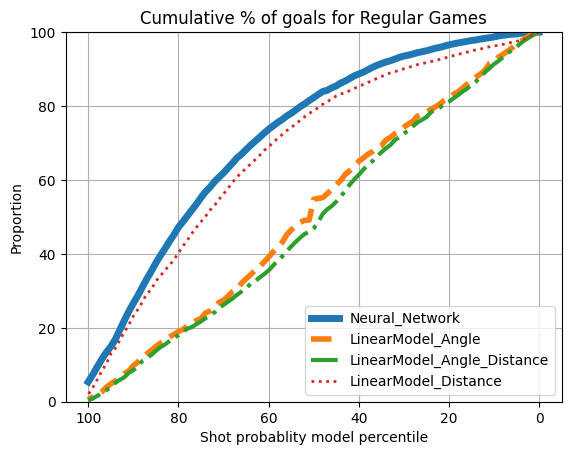

In [12]:
def plot_cumulative_goal(dataloader, x_val, y_val, k, ls, lw):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../downloaded_models/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(nn_model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        rf_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = rf_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "LinearModel_Angle":
        x_val = x_val[["angle"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle_Distance":
        x_val = x_val[["angle", "distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Distance":
        x_val = x_val[["distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list

    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = df.groupby(by='percentile_of_goal').sum()
    goal_rate['percentile'] = goal_rate.index
    
    goal_rate['cum_sum'] = goal_rate.loc[::-1, 'is_goal'].cumsum()[::-1]
    goal_rate['cum_perc'] = 100*goal_rate['cum_sum'] / goal_rate['is_goal'].sum()
    
    plt1.plot(goal_rate["percentile"], goal_rate["cum_perc"], label=k, linewidth=lw, linestyle=ls)

    
graph, (plt1) = plt.subplots(1, 1)

for index, (k, v) in enumerate(data_dict.items()):
    print("Cumulative Goal for BaseLine Model for features - ", k)
    lw=5-4*index/len(data_dict)
    ls=['-','--','-.',':'][index%4]
    plot_cumulative_goal(valdataloader, x_val, y_val, k, ls, lw)
        

plt1.set_ylim(0,100)
plt1.invert_xaxis()
plt1.set_xlabel('Shot probablity model percentile')
plt1.set_ylabel('Proportion')
plt.grid()
plt.title("Cumulative % of goals for Regular Games")
plt.legend()
comet_exp_obj.log_figure(figure_name="Cumulative % of goals for Regular Games", figure=plt,
                   overwrite=True, step=None)
    
plt.show()

Estimator Plot for BaseLine Model for features -  Neural_Network
Estimator Plot for BaseLine Model for features -  LinearModel_Angle
Estimator Plot for BaseLine Model for features -  LinearModel_Angle_Distance
Estimator Plot for BaseLine Model for features -  LinearModel_Distance


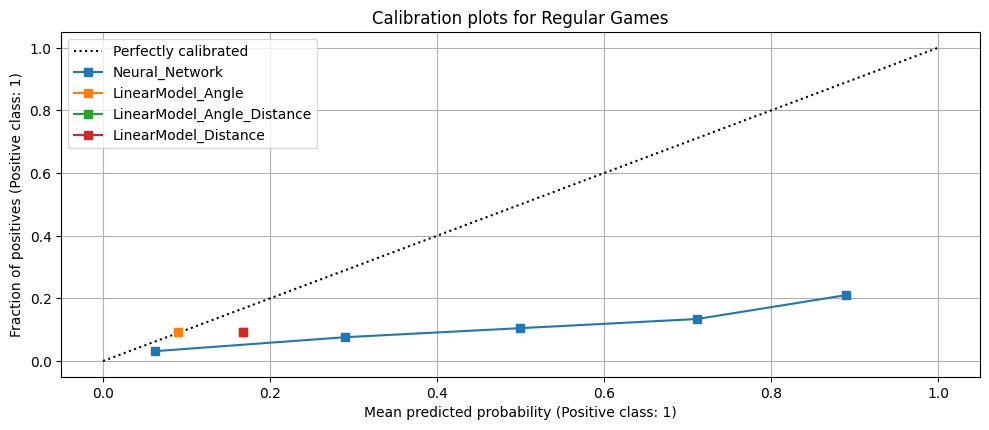

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/amandalmia/project-name-final-test-regular/475d9dd76f3642aca8180c35a189f1b6
COMET INFO:   Others:
COMET INFO:     Name : Final Evaluation Testing Regular
COMET INFO:   Uploads:
COMET INFO:     dataframe                : 2 (15.53 MB)
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (25.49 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 2 (397.48 KB)
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the follo

In [13]:
def create_estimator_plot(dataloader, x_val, y_val, k):
    if k == "Neural_Network":
        nn_model = NeuralNets()
        nn_model.load_state_dict(torch.load("../downloaded_models/" + k + "_Model.pth"))
        pred_list, testy, ns_probs = get_probs_nn(nn_model, dataloader)
        
    elif k == "kNN":
        knn_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = knn_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Random_Forest":
        rf_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = rf_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
        
    elif k == "Decision_Tree":
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle":
        x_val = x_val[["angle"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Angle_Distance":
        x_val = x_val[["angle", "distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    
    elif k == "LinearModel_Distance":
        x_val = x_val[["distance"]]
        dt_model = pickle.load(open("../downloaded_models/" + k + "_Model.pkl", 'rb'))
        pred_list = dt_model.predict_proba(x_val)
        testy = y_val
        ns_probs = [0 for _ in range(len(testy))]
    else:
        pass
    
    predicted_probablities = pred_list
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    return CalibrationDisplay.from_predictions(y_val, goal_prob, ax=ax_calibration_curve,name=k)
#     return CalibrationDisplay.from_estimator(model, x_val, y_val, ax=ax_calibration_curve, name=k)
    
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}


for index, (k, v) in enumerate(data_dict.items()):
    print("Estimator Plot for BaseLine Model for features - ", k)
    calibration_displays[k] = create_estimator_plot(valdataloader, x_val, y_val, k)
                
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots for Regular Games")
plt.tight_layout()
plt.legend(loc='upper left')

comet_exp_obj.log_figure(figure_name="Calibration Display for Regular Games", figure=plt,
                   overwrite=True, step=None)
plt.show()

comet_exp_obj.end()


    